In [1]:
## 训练深层神经网络

In [6]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import tensorflow as tf
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Saving figure sigmoid_saturation_plot


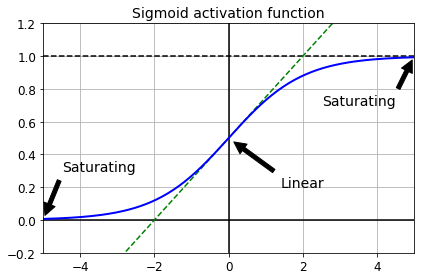

In [7]:
# 梯度消失/爆炸问题
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

In [4]:
# ELU > leaky ReLU（及其变体）> ReLU > tanh > sigmoid

In [5]:
# Xavier and He Initialization

In [8]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")


In [18]:
# Leaky ReLU
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


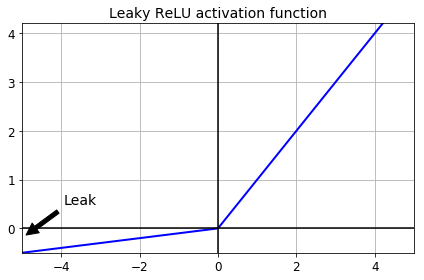

In [19]:
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [26]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

In [27]:
# Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [28]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [29]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [30]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [31]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [32]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [33]:
with tf.name_scope("eval"):
    # 用于计算预测的结果和实际结果的是否相等
    correct = tf.nn.in_top_k(logits, y, 1)
    # tf.cast bool -> 0 or 1
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [34]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [35]:
# Let's load the data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [37]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [38]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9496
10 Batch accuracy: 0.92 Validation accuracy: 0.9654
15 Batch accuracy: 0.94 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.9764
25 Batch accuracy: 1.0 Validation accuracy: 0.9778
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


In [39]:
# ELU

In [40]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


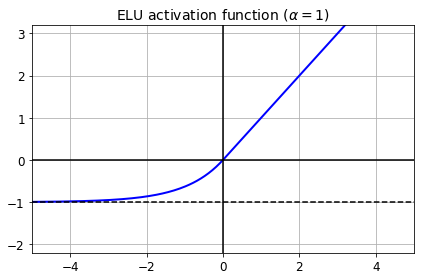

In [41]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [42]:
# SELU

def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Saving figure selu_plot


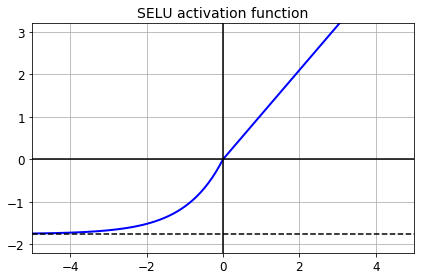

In [43]:

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [44]:
# 批量标准化

In [45]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [46]:

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [47]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [48]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [49]:
n_epochs = 20
batch_size = 200

In [50]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


In [51]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [52]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

In [54]:
# 复用 TensorFlow 模型

In [59]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [61]:
n_epochs = 20
batch_size = 200


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7936
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.9296
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.9474
12 Validation accuracy: 0.9478
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9568
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9574
17 Validation accuracy: 0.959
18 Validation accuracy: 0.9622
19 Validation accuracy: 0.9612


In [69]:
reset_graph()

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [70]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [71]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [72]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [73]:

with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9646
5 Validation accuracy: 0.9652
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9712
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9708
19 Validation accuracy: 0.9712


In [74]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [75]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9646
5 Validation accuracy: 0.9652
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9712
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9708
19 Validation accuracy: 0.9712


In [76]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [77]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9126
1 Validation accuracy: 0.9374
2 Validation accuracy: 0.946
3 Validation accuracy: 0.9498
4 Validation accuracy: 0.953
5 Validation accuracy: 0.9528
6 Validation accuracy: 0.9564
7 Validation accuracy: 0.96
8 Validation accuracy: 0.9616
9 Validation accuracy: 0.9612
10 Validation accuracy: 0.9634
11 Validation accuracy: 0.9626
12 Validation accuracy: 0.9648
13 Validation accuracy: 0.9656
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.967
16 Validation accuracy: 0.968
17 Validation accuracy: 0.9678
18 Validation accuracy: 0.9684
19 Validation accuracy: 0.9678
